In [30]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os
import os.path
import sys
import tensorflow as tf
import math
from data_loader import DataLoader
from my_constants import Constants
from emotion_classifier import EmotionClassifier
import numpy as np
import scipy
import pandas as pd

np.random.seed(0)

# Logistics

In [75]:
# BEST_CHECKPOINTS = {'none': 1068, 'aleatoric':1012 ,'epistemic': 319 , 'both':53} # TODO only none is done
BEST_CHECKPOINTS = {'none': 403, 'aleatoric':353 ,'epistemic': 406 , 'both':192}

model_name = 'FC'
batch_size = 90
seed = 666
filename = '/mas/u/asma_gh/uncnet/datasets/FER+/all.csv'
max_nrof_epochs=100000
hidden_layer_size=[128, 128]
keep_probability=0.8
weight_decay=0.0
n_epistemic = 100
n_aleatoric = 100

logs_base_dir = '/mas/u/asma_gh/uncnet/epoch_logs_model'
embedding_model = 'CASIA_WebFace_Inception_ResNet_v1'
embedding_layer = 'Mixed_7a'
learning_rate = 0.0001

# Load data

In [5]:
def load_model_dir(uncertainty_type):
    epoch_num = BEST_CHECKPOINTS[uncertainty_type]
    model_filename = f'{model_name}_{epoch_num}.ckpt-{epoch_num}'
    root_dir = f'{logs_base_dir}/{embedding_model}/{embedding_layer}/{str(learning_rate)}/{uncertainty_type}'
    
    model_dir = None
    for sub_dir in os.listdir(root_dir):
        if sub_dir.startswith('.'):
            continue
        model_dir = os.path.join(os.path.join(root_dir, sub_dir), model_filename)
    if not model_dir:
        print ('Error! Did not find model.')
        return None
    return model_dir

In [6]:
data_loader = DataLoader(filename, import_embedding=True, embedding_model=embedding_model,
                                      embedding_layer=embedding_layer, seed=seed)

Converting row 0 of dataframe to numpy array.
Converting row 100 of dataframe to numpy array.
Converting row 200 of dataframe to numpy array.
Converting row 300 of dataframe to numpy array.
Converting row 400 of dataframe to numpy array.
Converting row 500 of dataframe to numpy array.
Converting row 600 of dataframe to numpy array.
Converting row 700 of dataframe to numpy array.
Converting row 800 of dataframe to numpy array.
Converting row 900 of dataframe to numpy array.
Converting row 1000 of dataframe to numpy array.
Converting row 1100 of dataframe to numpy array.
Converting row 1200 of dataframe to numpy array.
Converting row 1300 of dataframe to numpy array.
Converting row 1400 of dataframe to numpy array.
Converting row 1500 of dataframe to numpy array.
Converting row 1600 of dataframe to numpy array.
Converting row 1700 of dataframe to numpy array.
Converting row 1800 of dataframe to numpy array.
Converting row 1900 of dataframe to numpy array.
Converting row 2000 of dataframe

Converting row 14800 of dataframe to numpy array.
Converting row 14900 of dataframe to numpy array.
Converting row 15000 of dataframe to numpy array.
Converting row 15100 of dataframe to numpy array.
Converting row 15200 of dataframe to numpy array.
Converting row 15300 of dataframe to numpy array.
Converting row 15400 of dataframe to numpy array.
Converting row 15500 of dataframe to numpy array.
Converting row 15600 of dataframe to numpy array.
Converting row 15700 of dataframe to numpy array.
Converting row 15800 of dataframe to numpy array.
Converting row 15900 of dataframe to numpy array.
Converting row 16000 of dataframe to numpy array.
Converting row 16100 of dataframe to numpy array.
Converting row 16200 of dataframe to numpy array.
Converting row 16300 of dataframe to numpy array.
Converting row 16400 of dataframe to numpy array.
Converting row 16500 of dataframe to numpy array.
Converting row 16600 of dataframe to numpy array.
Converting row 16700 of dataframe to numpy array.


Converting row 29200 of dataframe to numpy array.
Converting row 29300 of dataframe to numpy array.
Converting row 29400 of dataframe to numpy array.
Converting row 29500 of dataframe to numpy array.
Converting row 29600 of dataframe to numpy array.
Converting row 29700 of dataframe to numpy array.
Converting row 29800 of dataframe to numpy array.
Converting row 29900 of dataframe to numpy array.
Converting row 30000 of dataframe to numpy array.
Converting row 30100 of dataframe to numpy array.
Converting row 30200 of dataframe to numpy array.
Converting row 30300 of dataframe to numpy array.
Converting row 30400 of dataframe to numpy array.
Converting row 30500 of dataframe to numpy array.
Converting row 30600 of dataframe to numpy array.
Converting row 30700 of dataframe to numpy array.
Converting row 30800 of dataframe to numpy array.
Converting row 30900 of dataframe to numpy array.
Converting row 31000 of dataframe to numpy array.
Converting row 31100 of dataframe to numpy array.


In [17]:
test_labels, test_embeddings = data_loader.get_test_batch()
valid_labels, valid_embeddings = data_loader.get_valid_batch()

# Load model

In [26]:
def get_performance_on_data(uncertainty_type, x, y):
    model_dir = load_model_dir(uncertainty_type)
    tf.reset_default_graph()
    with tf.Session() as sess:    
        saver = tf.train.import_meta_graph(f'{model_dir}.meta')
        saver.restore(sess, model_dir)
        
        tf_loss = tf.get_default_graph().get_tensor_by_name("loss:0")
        tf_acc = tf.get_default_graph().get_tensor_by_name("acc:0")
        tf_x = tf.get_default_graph().get_tensor_by_name("x:0")
        tf_y = tf.get_default_graph().get_tensor_by_name("y:0")
        tf_dropout_prob = tf.get_default_graph().get_tensor_by_name("dropout_prob:0")
        
        tf_logits = tf.get_default_graph().get_tensor_by_name("logits:0")
        if uncertainty_type == 'aleatoric' or uncertainty_type == 'both':
            tf_logits_mean = tf.get_default_graph().get_tensor_by_name("logits_mean:0")
            tf_logits_var = tf.get_default_graph().get_tensor_by_name("logits_var:0")

        aleatoric_u = None
        epistemic_u = None

        def mc_epistemic_sampling():
            mc_logits = []
            mc_losses = []
            for i in range(n_epistemic):
                loss, logits = sess.run([tf_loss, tf_logits], feed_dict={
                    tf_x: x, tf_y: y, tf_dropout_prob: keep_probability})
                mc_logits.append(logits)
                mc_losses.append(loss)
            mean_logits = np.mean(mc_logits, axis=0)
            score = calc_acc(mean_logits, y)
            epistemic_u = np.var(mc_logits, axis=(0,2))
            return mc_logits, np.mean(mc_losses), score, epistemic_u

        def calc_acc(logits, y):
            class_probabilities = scipy.special.softmax(logits)
            predictions = np.argmax(class_probabilities, axis=1)
            target = np.argmax(y, axis=1)
            acc = np.mean(np.equal(target, predictions))
            return acc

        """Returns the model's performance on input data X and targets Y."""
        if uncertainty_type == 'none':
            loss, score, logits = sess.run([tf_loss, tf_acc, tf_logits], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
        elif uncertainty_type == 'aleatoric':
            loss, score, logits, aleatoric_u = sess.run([tf_loss, tf_acc, tf_logits_mean, tf_logits_var], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
        elif uncertainty_type == 'epistemic':
            mc_logits, loss, score, epistemic_u = mc_epistemic_sampling()
        elif uncertainty_type == 'both':
            aleatoric_u = sess.run(tf_logits_var, feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
            mc_logits, loss, score, epistemic_u = mc_epistemic_sampling()

        return loss, score, aleatoric_u, epistemic_u

# Q1: Does modeling uncertainty improve accuracy?

#### Sanity check
Do the validation results map the tensorboard?

In [ ]:
# Get validation results
print ('Validation set:')
for unc in unc_types:
    print (f'\nModeling {unc} uncertainties...')
    loss, score, aleatoric_u, epistemic_u = get_performance_on_data(unc, valid_embeddings, valid_labels)
    print(f'loss: {loss:.5f}, score: {score:.5f}, aleatoric_u: {aleatoric_u}, epistemic_u: {epistemic_u}')

#### How about the unseen test set?

In [76]:
unc_types = ['none', 'aleatoric', 'epistemic', 'both']  
# Get test results
print ('Test set:')
for unc in unc_types:
    print (f'\nModeling {unc} uncertainties...')
    loss, score, aleatoric_u, epistemic_u = get_performance_on_data(unc, test_embeddings, test_labels)
    print(f'loss: {loss:.5f}, score: {score:.5f}, aleatoric_u: {aleatoric_u}, epistemic_u: {epistemic_u}')

Test set:

Modeling none uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.49306, score: 0.54848, aleatoric_u: None, epistemic_u: None

Modeling aleatoric uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/aleatoric/2019_04_22_10_36_21/FC_353.ckpt-353
loss: 1.50303, score: 0.55462, aleatoric_u: [5.2196071e-07 8.0424499e-08 1.2522859e-06 ... 2.9611423e-15 1.2167646e-08
 4.1647163e-13], epistemic_u: None

Modeling epistemic uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/epistemic/2019_04_22_10_36_21/FC_406.ckpt-406
loss: 1.57032, score: 0.53842, aleatoric_u: None, epistemic_u: [1.1245508  0.7752564  0.92051166 ... 2.5161495  0.9675494  1.371409  ]



# Q2: Does excluding the points with high uncertainty, improve accuracy?

In [91]:
dataset = pd.read_csv(filename)
test = dataset[dataset['dataset'] == 'PublicTest'].reset_index(drop=True)
test['original_ind'] = test.index

In [92]:
_, _, aleatoric_u, epistemic_u = get_performance_on_data('both', test_embeddings, test_labels)

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/both/2019_04_22_10_36_21/FC_192.ckpt-192


In [93]:
test['aleatoric_u'] = aleatoric_u*1000000.0
test['epistemic_u'] = epistemic_u

In [94]:
def find_unc_samples(test, uncertainty_type, percentage=0.75, sort_ascending=True):
    '''
    Find samples that are in the [percentage] quantile with 
    highest or lowest uncertainty values based on [sort_ascending]
    '''
    test = test.sort_values(by=f'{uncertainty_type}_u', ascending=sort_ascending)
    max_ind = int(percentage*len(test))
    sub_index = test.index[0:max_ind]
    return sub_index

for unc in ['aleatoric', 'epistemic']:
    print (f'Sorting based on uncertainty type: {unc}...')
    sub_indices = find_unc_samples(test, unc)
    sub_test_embeddings = test_embeddings[sub_indices]
    sub_test_labels = test_labels[sub_indices]
    for unc_type in ['none', 'both']:
        print(f'New performance metrics for {unc_type}:')
        loss, score, aleatoric_u, epistemic_u = get_performance_on_data(unc_type, sub_test_embeddings, sub_test_labels)
        print(f'loss: {loss:.5f}, score: {score:.5f}, aleatoric_u: {aleatoric_u}, epistemic_u: {epistemic_u}')
        

Sorting based on uncertainty type: aleatoric...
New performance metrics for none:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.39093, score: 0.59352, aleatoric_u: None, epistemic_u: None
New performance metrics for both:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/both/2019_04_22_10_36_21/FC_192.ckpt-192
loss: 1.45633, score: 0.59240, aleatoric_u: [3.3341643e-18 8.5186077e-17 2.6620660e-16 ... 1.6001354e-07 1.6027806e-07
 1.6060689e-07], epistemic_u: [9.834153  5.749763  5.8443837 ... 1.0434337 1.0451131 1.073201 ]
Sorting based on uncertainty type: epistemic...
New performance metrics for none:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
los

# Q3: Is there a relationship between inter-rater agreement and uncertainty?

<Figure size 360x360 with 0 Axes>

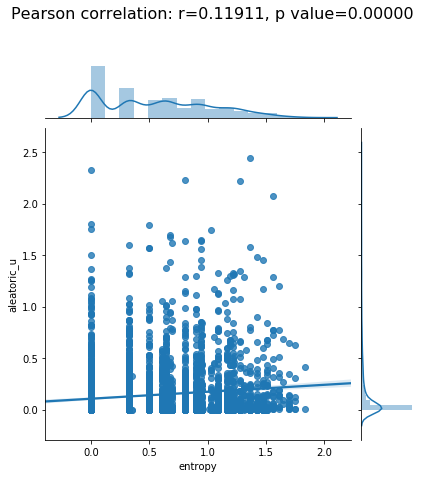

<Figure size 360x360 with 0 Axes>

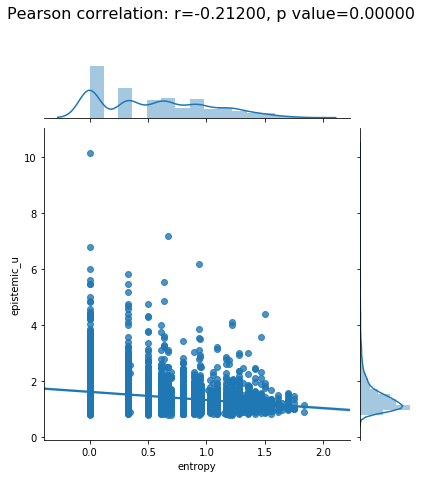

<Figure size 360x360 with 0 Axes>

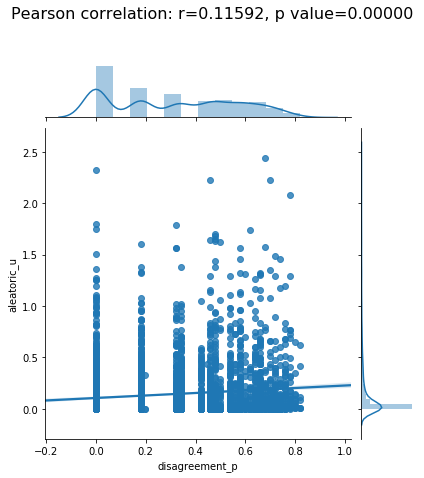

<Figure size 360x360 with 0 Axes>

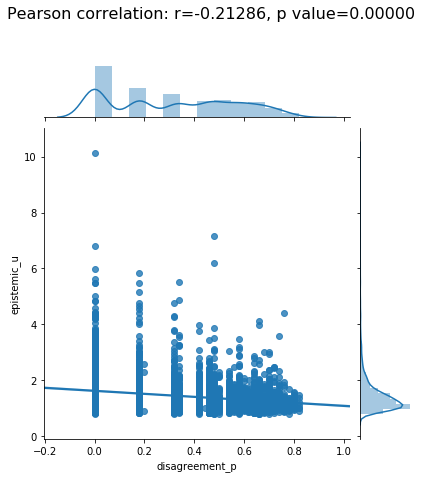

In [95]:
def comparison_plots(test, x, y):
    plt.figure(figsize=(5,5))
    g = sns.jointplot(test[x], test[y], kind="reg")
    r, p = scipy.stats.pearsonr(test[x], test[y])
    plt.suptitle(f'Pearson correlation: r={r:.5f}, p value={p:.5f}', size=16, y=1.1)
    plt.ylabel(y)
    plt.xlabel(x)
    
for x in ['entropy', 'disagreement_p']:
    comparison_plots(test, x, 'aleatoric_u')
    comparison_plots(test, x, 'epistemic_u')


# Q4: What do the points with high/low aleatoric/epistemic uncertainty look like?

Uncertainty type: aleatoric
Uncertainty type: epistemic


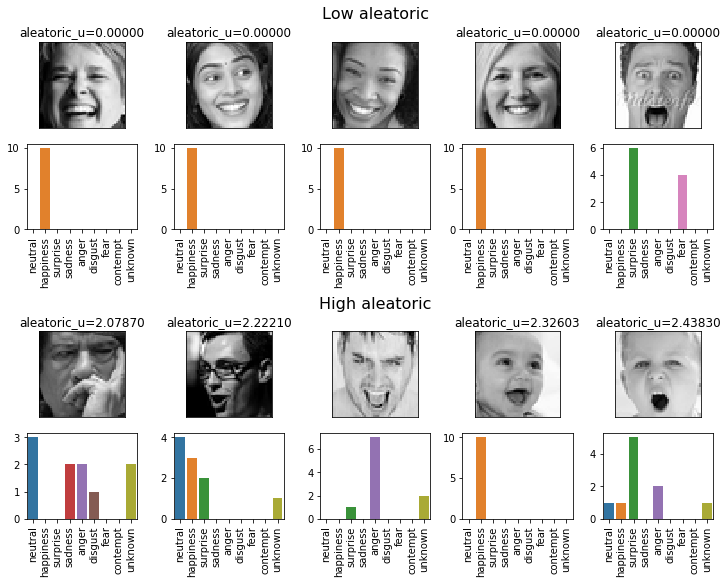

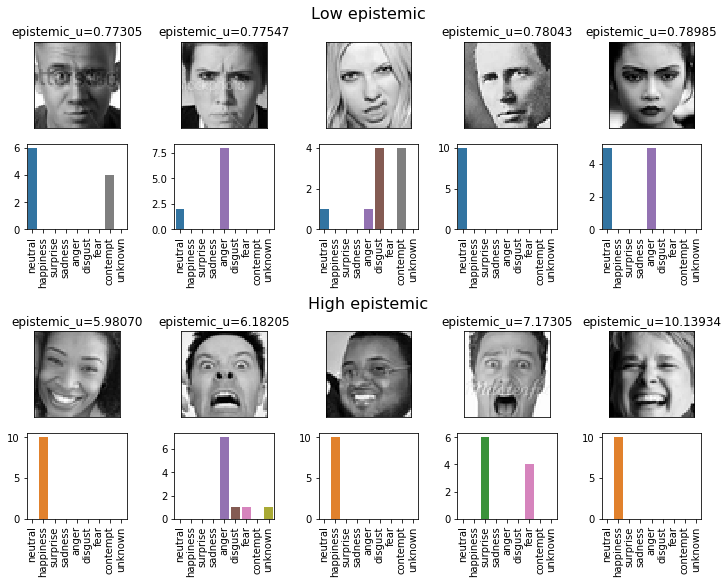

In [97]:
EMOTION_COLS = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt' ,'unknown']
def _plot_img_hist(inp, axes, ax_i, ax_j, ttl_col):
    img_ax = axes[ax_i, ax_j]
    hist_ax = axes[ax_i+1, ax_j]
    
    NEW_SHAPE = (48, 48)
    img_arr = np.array([int(i) for i in inp['pixels'].split(' ')])
    img_arr = np.reshape(img_arr, NEW_SHAPE)
    img_ax.set_title(f'{ttl_col}={inp[ttl_col]:.5f}')
    img_ax.imshow(img_arr, cmap='gray')
    img_ax.set_xticks([])
    img_ax.set_yticks([])
    
    sns.barplot(np.arange(len(EMOTION_COLS)), list(inp[EMOTION_COLS]), ax=hist_ax)
    hist_ax.set_xticklabels(EMOTION_COLS, rotation='vertical')


# Show n images with highest disagreement and n images with lowest disagreement probability
def show_extreme_cases(inp, n, ttl_col):
    f, axes = plt.subplots(4, n, figsize=(n*2, 8), constrained_layout=True)
    for i in range(n):
        _plot_img_hist(inp.iloc[i], axes, 0, i, f'{ttl_col}_u')
    axes[0, int(n/2)].set_title(f'Low {ttl_col}', size=16, y=1.2)
    
    for i in range(n):
        _plot_img_hist(inp.iloc[len(inp)-1-i], axes, 2, n-i-1, f'{ttl_col}_u')
    axes[2, int(n/2)].set_title(f'High {ttl_col}', size=16, y=1.2)

for unc in ['aleatoric', 'epistemic']:
    print (f'Uncertainty type: {unc}')
    sorted_test = test.sort_values(by=f'{unc}_u')
    show_extreme_cases(sorted_test, 5, unc)
    
    